
# TRAIN MODEL

Sources:
1.   https://rubikscode.net/2020/06/22/pytorch-for-beginners-deploying-models-with-torchserve/
2.   https://rubikscode.net/2021/08/02/pytorch-for-beginners-building-neural-networks/

Dataset: Fashion MNIST Dataset

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [3]:
data = FashionMNIST(root='data/', download=True, transform=ToTensor())

validation_size = 10000
train_size = len(data) - validation_size

train_data, val_data = random_split(data, [train_size, validation_size])

batch_size=128

train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
class FFNN(nn.Module):
    """Simple Feed Forward Neural Network with n hidden layers"""
    def __init__(self, input_size, num_hidden_layers, hidden_size, out_size, accuracy_function):
        super().__init__()
        self.accuracy_function = accuracy_function
        
        # Create first hidden layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Create remaining hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(0, num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Create output layer
        self.output_layer = nn.Linear(hidden_size, out_size)
        
    def forward(self, input_image):
        # Flatten image
        input_image = input_image.view(input_image.size(0), -1)
        
        # Utilize hidden layers and apply activation function
        output = self.input_layer(input_image)
        output = F.relu(output)
        
        for layer in self.hidden_layers:
            output = layer(output)
            output = F.relu(output)
        
        # Get predictions
        output = self.output_layer(output)
        return output
    
    def training_step(self, batch):
        # Load batch
        images, labels = batch
        
        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)
        return loss
    
    def validation_step(self, batch):
        # Load batch
        images, labels = batch 

        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)

        # Calculate accuracy
        acc = self.accuracy_function(output, labels)
        
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        
        # Combine losses and return mean value
        epoch_loss = torch.stack(batch_losses).mean()
        
        # Combine accuracies and return mean value
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch: {} - Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [12]:
class ModelTrainer():   
    def fit(self, epochs, learning_rate, model, train_loader, val_loader, opt_func=torch.optim.SGD):
        history = []
        optimizer = opt_func(model.parameters(), learning_rate)

        for epoch in range(epochs):
            # Training 
            for batch in train_loader:
                loss = model.training_step(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # Validation
            result = self._evaluate(model, val_loader)
            model.epoch_end(epoch, result)
            history.append(result)
            
        return history

    def _evaluate(self, model, val_loader):
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def plot_history(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Loss and Accuracy')

In [14]:
input_size = 784
num_classes = 10
num_hidden_layers = 3

model = FFNN(input_size, num_hidden_layers, 32, out_size=num_classes, accuracy_function=accuracy)
print(model)

FFNN(
  (input_layer): Linear(in_features=784, out_features=32, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 - Validation Loss: 0.8372, Validation Accuracy: 0.6883
Epoch: 1 - Validation Loss: 0.5218, Validation Accuracy: 0.8093
Epoch: 2 - Validation Loss: 0.4529, Validation Accuracy: 0.8335
Epoch: 3 - Validation Loss: 0.4078, Validation Accuracy: 0.8505
Epoch: 4 - Validation Loss: 0.4224, Validation Accuracy: 0.8519


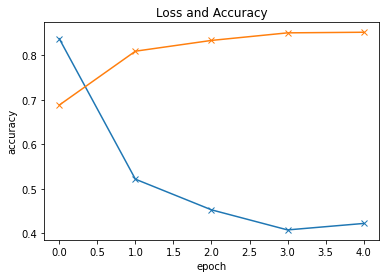

In [15]:
model_trainer = ModelTrainer()

training_history = []
training_history += model_trainer.fit(5, 0.2, model, train_loader, val_loader)

plot_history(training_history)

In [45]:
torch.save(model.state_dict(), 'ffnn.torch')

In [20]:
!pip install onnx

     |████████████████████████████████| 12.7 MB 5.5 MB/s 


In [24]:
import onnx

random_input = torch.randn(1, 784, requires_grad=True)
torch.onnx.export(model, random_input, "ffnn.onnx")

# CONVERT MODEL TO NPY FILES

In [38]:
import numpy as np

PATH = "ffnn.onnx"

print(model)

np.save("0-WEIGHT-ffnn.npy", model.input_layer.weight.detach().numpy())
np.save("1-WEIGHT-ffnn.npy", model.hidden_layers[0].weight.detach().numpy())
np.save("2-WEIGHT-ffnn.npy", model.hidden_layers[1].weight.detach().numpy())
np.save("3-WEIGHT-ffnn.npy", model.hidden_layers[2].weight.detach().numpy())
np.save("4-WEIGHT-ffnn.npy", model.output_layer.weight.detach().numpy())

FFNN(
  (input_layer): Linear(in_features=784, out_features=32, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
)


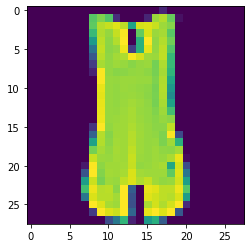

In [44]:
import gzip
f = gzip.open('./data/FashionMNIST/raw/train-images-idx3-ubyte.gz','r')

image_size = 28
num_images = 5

import numpy as np
import matplotlib.pyplot as plt

f.read(16)
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)
image = np.asarray(data[4]).squeeze()
plt.imshow(image)
plt.savefig('sample.png')